# **Tutorial 4 : Ice-Albedo Feedback**


**Week 1, Day 5, Climate Modeling**

**Content creators:** Jenna Pearson, Brodie Pearson, and Abigail Bodner

**Content reviewers:** Draco Xu

**Content editors:** TBD

**Production editors:** TBD

**Our 2023 Sponsors:** TBD


Link to paleo climate and also to brodie's speaker slides on tipping points.

add colorbar to last plots

fill in objectives



# **Tutorial Objectives**

In this tutorial students will learn about the temperature dependent albedo, and how changing the insolation affects the equilibrium temperature.

By the end of this tutorial students will be able to:
* Apply a function of temeperature dependent albedo to their existing climate model.
* Understand the impact of insolation on the equilibrium temperature, and how this relates to snowball and hothouse Earth.

# Setup

In [2]:
import xarray as xr                     # used to manipulate data and open datasets
import numpy as np                      # used for algeba and array operations
import matplotlib.pyplot as plt         # used for plotting
from scipy.optimize import brentq       # used for numerical root-finding to get the equilibria

In [3]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [4]:
# @title Video 1: A Zero-Dimensional Energy Balance Model
#Tech team will add code to format and display the video

# Section 1 : Ice-Albedo Feedback

## Section 1.1 : Temperature Dependent Albedo

As is, our model only contains what is called a 'Plank feedback' or a 'Planck temperature response'. This is principly because as we warm we emit more energy (see Planck's law from Tutorial 1). In reality, there are many feedbacks that contribute to the Earth's net temperature change. In this tutorial we will focus on incorporating an ice-albedo feedback into our model.

When earth's surface warms, snow and ice melt. This decreases the amount of solar radiation that is reflected off Earth's surface, and lowers the **albedo (**$\mathbf{\alpha}$**)**. This in turn warms the climate and more snow and ice melt. This is referred to as a **postive feedback**. Positive feedbacks amplify the changes that are already occurring. This particular feedback is referred to as the **ice-albedo feedback**.

A simple introduction of this feature is through a temperature dependent albedo defined below (see the tutorial lecutre slides for an explanation of why we use this function).

\begin{align}
\alpha = \left\{
        \begin{array}{cl}
        0.1 & T \gt 300 K \\
        0.1 + (0.7-0.1) \cdot \frac{(T-300)^2}{(240-300)^2} & 240 \le T \le 300 \\
        0.7 & T \lt 240
        \end{array}
        \right.
\end{align}

With the new albedo definition, we can plot the graphs of absorbed shortwave radiation (ASR) and outgoing longwave radiation (OLR).

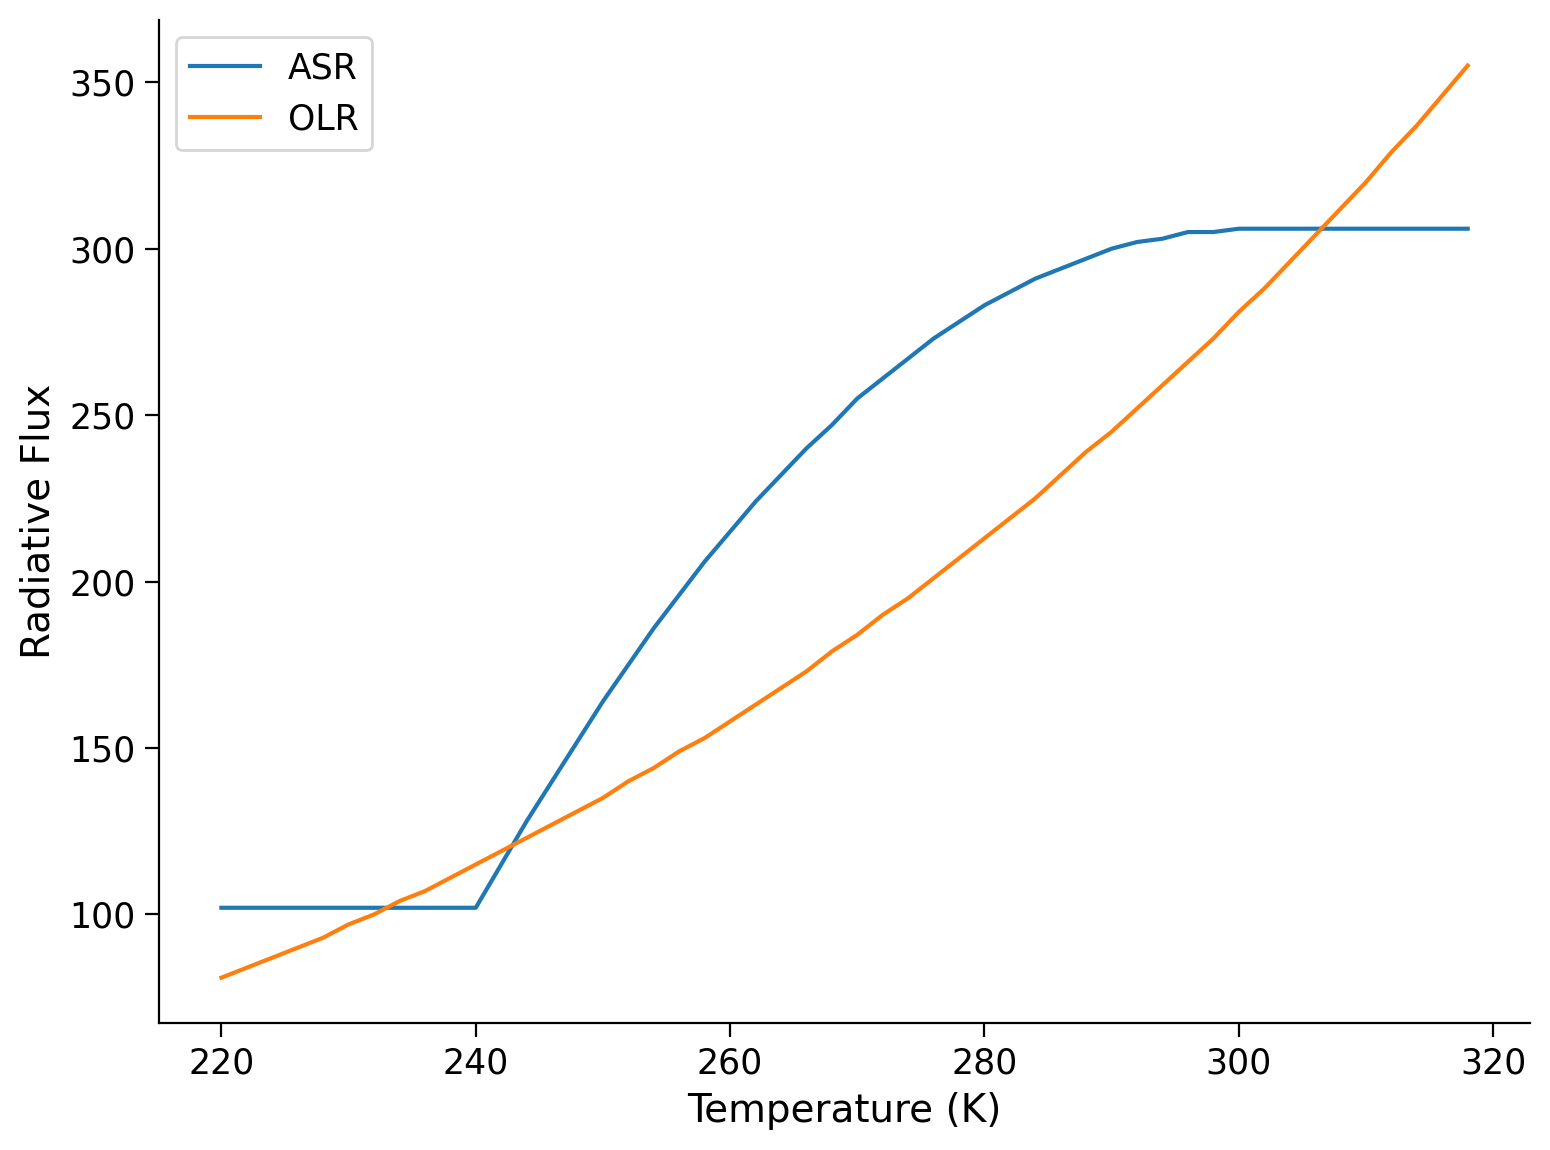

In [10]:
# create a array ot temperatures to evaluates the ASR and OLR at
T = np.arange(220,320,2)

#create empty arrays to fill with values later
ASR = np.zeros_like(T)
OLR = np.zeros_like(T)

# define the slope of the ramp function
m = (0.7-0.3)/(280-250)

# define the observed insolation based on observations from the IPCC AR6 Figure 7.2
Q = 340 # W m^-2

# define transmissivity (calculated previously from observations in tutorial 1)
tau = 0.6127 # unitless number between 0 and 1

# define the Stefan-Boltzmann Constant, noting we are using 'e' for scientific notation
sigma = 5.67e-8 # W m^-2 K^-4

# calculate ASR and OLR for different values of T
for tt, temp in enumerate(T):

    # define function for albedo
    if temp >= 300:                # temperature of very warm and ice free earth.
        alpha=0.1                  # average albedo of land and sea without ice
    elif temp>240:                 # temperature of Earth to sustain permafrost and sea ice everywhere.
        alpha=0.1 + (0.7-0.1)*(temp-300)**2/(240-300)**2
    else:
        alpha=0.7                   # average albedo of land and sea ice

    ASR[tt] = (1-alpha)*Q
    OLR[tt] = tau * sigma * temp**4

# make plots
plt.plot(T,ASR, label = 'ASR')
plt.plot(T,OLR, label = 'OLR')

plt.title('', fontsize=16)
plt.xlabel('Temperature (K)', fontsize=14)
plt.ylabel('Radiative Flux',fontsize=14)
plt.legend()

### Questions 1.1

1. How many times do the graphs of ASR and OLR intersect?
2. What does this intersection mean in terms of energy balance?

In [9]:
# to_remove explanation

"""
1. Three.
2. When the graphs intersect, it means that ASR = OLR, and thus ASR-OLR = 0. These three intersections are the three temperatures for which energy balance is satisfied in our model.
"""

'\n1. Three.\n2. When the graphs intersect, it means that ASR = OLR, and thus ASR-OLR = 0. These three intersections are the three temperatures for which energy balance is satisfied in our model.\n'

## Section 1.2 : Multiple Equilibria From Graphs


**Equilibria** are solutions to the model equation when the rate of change of tempearture is zero. Graphically, equilibria represent the long-term behavior of the temperature curves.

A *stable equilibrium* temperature is what the model converges to (moves towards) after a long time. An *unstable equilibrium* temperature is a solution to the equation that the model diverges (moves away) from over time. 
 
We can now include this temperature dependent albedo into the time dependent model we created in Tutorial 3 and investigate the long-term behavior of our temperature curves. Note we will be using a the function we created 

In [25]:
# create a function to find the new tempeature based on the previous using Euler's method.
def step_forward(T,tau,Q):

    # define the heat capacity (calculated in Tutorial 3)
    C = 286471954.64 # J m^-2K^-2

    # define function for albedo
    if T >= 300:                # temperature of very warm and ice free earth.
        alpha=0.1                  # average albedo of land and sea without ice
    elif T>240:                 # temperature of Earth to sustain permafrost and sea ice everywhere.
        alpha=0.1 + (0.7-0.1)*(T-300)**2/(240-300)**2
    else:
        alpha=0.7                   # average albedo of land and sea ice

    # define the Stefan-Boltzmann Constant, noting we are using 'e' for scientific notation
    sigma = 5.67e-8 # W m^-2 K^-4

    ASR = (1-alpha)*Q
    OLR = tau * sigma * T**4

    T_new = T + dt / C * ( ASR - OLR )

    return T_new

Let us explore how our model behaves under a variety of intial temperatures. We can use a for loop to help us use our model interativly.

Text(0, 0.5, 'Temperature (C)')

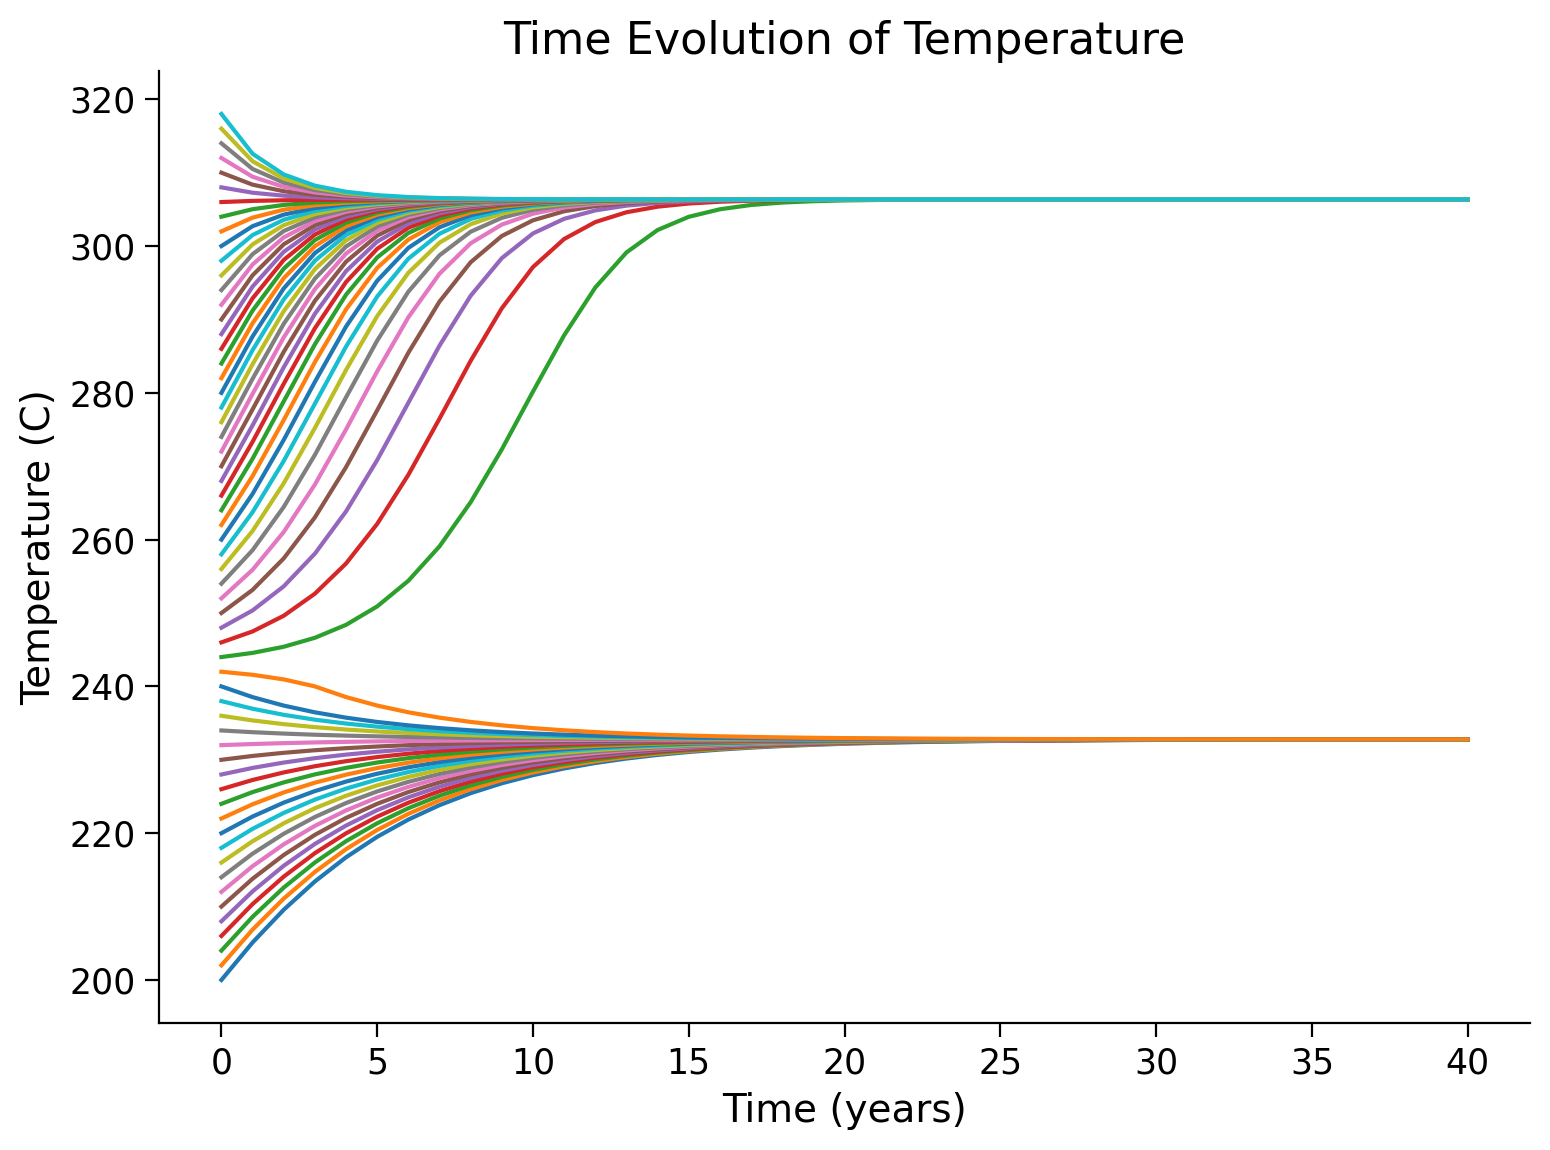

In [26]:
dt = 60. * 60. * 24. * 365.   # time interval, one year expressed in seconds

# define transmissivity (calculated previously from observations in tutorial 1)
tau = 0.6127 # unitless number between 0 and 1

# define the observed insolation based on observations from the IPCC AR6 Figure 7.2
Q = 340 # W m^-2

for init_temp in range(200,320,2):  # suite of intial temperatures in K
      numtsteps = 40     #  number of years to run the model

      # for converting number of seconds in a year
      sec_2_yr = 3.154e7

      # set the intial temperature (initial condition)
      T_series = [init_temp]

      # set the initial time to 0
      t_series = [0]

      # run the model
      for n in range(numtsteps):

          # calculate and append the time since running the model, dependent on dt and the numtsteps
          t_series.append((n+1)*dt/sec_2_yr)

          # calculate and append the new temperature using our pre-defined function
          T_series.append(step_forward( T_series[n], tau = tau, Q = Q ))

      # make plot
      plt.plot(t_series,T_series)

plt.title('Time Evolution of Temperature', fontsize=16)
plt.xlabel('Time (years)', fontsize=14)
plt.ylabel('Temperature (C)',fontsize=14)

### Questions 1.2

1. How many stable equilibria can you find on the figure above? Estimate their values.
2. Can you spot the single unstable equilibria? Estimate it's value.
3. What do these values represent on the figure you made from Part 1?

In [27]:
# to_remove explanation

"""
1. Two. Near 235 K and 310K.
2. Near 245K.
3. They are the temperatures at which the the ASR and OLR curves intersect, or energy balance is achieved.
"""

'\n1. Two. Near 235 K and 310K.\n2. Near 245K.\n3. They are the temperatures at which the the ASR and OLR curves intersect, or energy balance is achieved.\n'

## Section 1.3: Finding Equilibria Numerically, Determining Convergence or Divergence

To verify the equilibria identified graphically in the previous section, we can use python to find the solutions to the equation when the rate of change in temeparture is zero. That is find the solution to 

\begin{align}
0 = ASR-OLR
\end{align}

To aid us, we will use a 'root-finding function' from the scipy package.

In [29]:
### below we have modified things a bit to use a root solver

# define transmissivity (calculated previously from observations in tutorial 1)
tau = 0.6127 # unitless number between 0 and 1

# define the observed insolation based on observations from the IPCC AR6 Figure 7.2
Q = 340 # W m^-2

# define the Stefan-Boltzmann Constant, noting we are using 'e' for scientific notation
sigma = 5.67e-8 # W m^-2 K^-4


def ASR(T, Q):

    # define function for albedo
    if T >= 300:                # temperature of very warm and ice free earth.
        alpha=0.1                  # average albedo of land and sea without ice
    elif T>240:                 # temperature of Earth to sustain permafrost and sea ice everywhere.
        alpha=0.1 + (0.7-0.1)*(T-300)**2/(240-300)**2
    else:
        alpha=0.7                   # average albedo of land and sea ice

    return Q * (1-alpha)

def OLR(T, sigma, tau):
    return tau * sigma * T**4

def Ftoa(T):
    return ASR(T,Q) - OLR(T,sigma,tau)

#  it requires a function and two end-points be input as arguments
#  it will look for a zero of the function between those end-points
Teq1 = brentq(Ftoa, 200., 240.) # these ranges are from the intersections of the graphs of ASR and OLR
Teq2 = brentq(Ftoa, 240., 280.)
Teq3 = brentq(Ftoa, 280., 320.)

print( Teq1, Teq2, Teq3)

232.77820135617048 242.83054107162232 306.3533415866786


To asess the stability of these equilibria, we can plot the difference in ASR and OSR. This is the same function we used the brentq package on to find the temperatures at which the energy difference was zero. Thus, when the graph here is zero, those are the equilibrium values.

Text(0, 0.5, 'ASR-OLR')

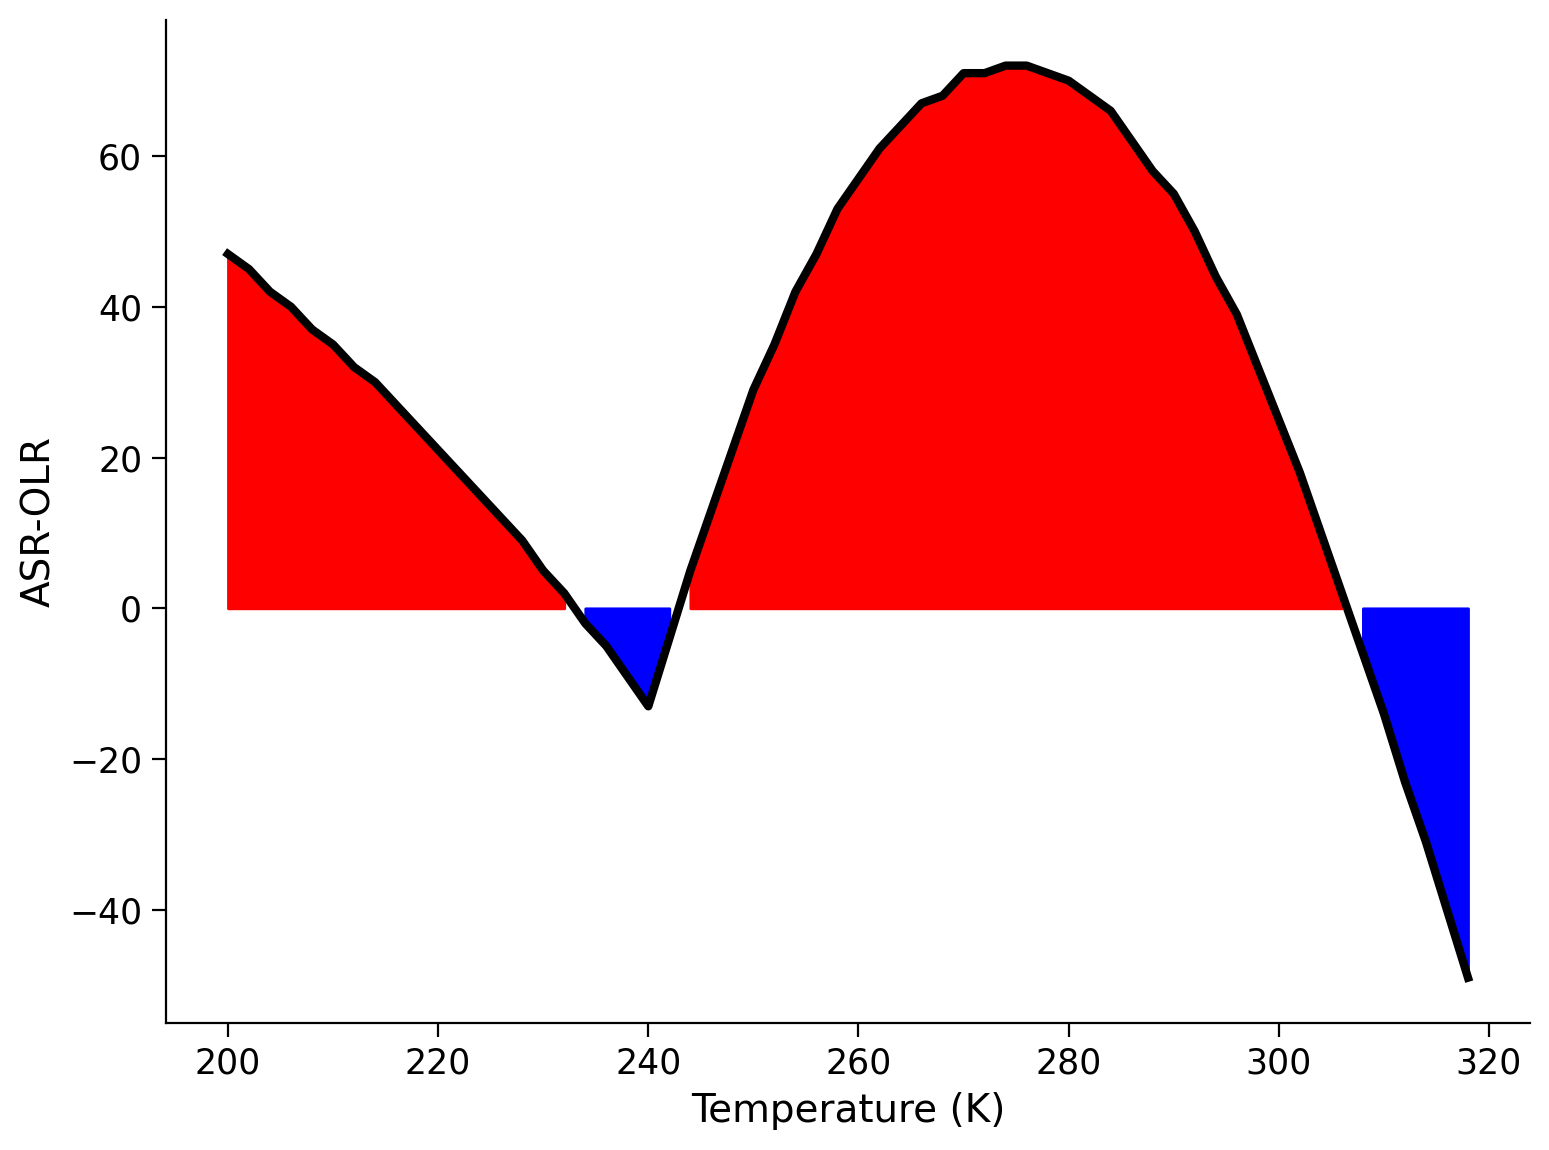

In [32]:
T = np.arange(200,320,2)
ASR = np.zeros_like(T)
OLR = np.zeros_like(T)

# define the observed insolation based on observations from the IPCC AR6 Figure 7.2
Q = 340 # W m^-2

# define transmissivity (calculated previously from observations in tutorial 1)
tau = 0.6127 # unitless number between 0 and 1

# define the Stefan-Boltzmann Constant, noting we are using 'e' for scientific notation
sigma = 5.67e-8 # W m^-2 K^-4

for tt, temp in enumerate(T):

    # define function for albedo
    if temp >= 300:                # temperature of very warm and ice free earth.
        alpha=0.1                  # average albedo of land and sea without ice
    elif temp>240:                 # temperature of Earth to sustain permafrost and sea ice everywhere.
        alpha=0.1 + (0.7-0.1)*(temp-300)**2/(240-300)**2
    else:
        alpha=0.7                   # average albedo of land and sea ice

    ASR[tt] = (1-alpha)*Q
    OLR[tt] = tau * sigma * temp**4

F = ASR-OLR
plt.plot(T,F, color = 'k', linewidth = 3)

# find positive values and fill with red
pos_ind1 = T<=Teq1
plt.fill_between(T[pos_ind1], 0, F[pos_ind1], color='red')

pos_ind2 = (T>=Teq2) & (T<=Teq3)
plt.fill_between(T[pos_ind2], 0, F[pos_ind2], color='red')

# find negative values and fill with red
neg_ind1 = (T>=Teq1) & (T<=Teq2)
plt.fill_between(T[neg_ind1], 0, F[neg_ind1], color='blue')

neg_ind2 = T>=Teq3
plt.fill_between(T[neg_ind2], 0, F[neg_ind2], color='blue')

plt.xlabel('Temperature (K)', fontsize=14)
plt.ylabel('ASR-OLR',fontsize=14)

The red regions represent where the energy absorbed in the Earth system is greater than that released to space. Thus, the temperature is increasing. The blue regions represent temperatures where the outgoing radiation is larger than the absorbed radiation, and so Earth is cooling.

If for example, starting from an initial temperature below $T_{eq1}$ (which is in a red region), it will move to the right on the X axis, towards this equilibrium point. Conversely if starting between $T_{eq1}$ and $T_{eq1}$, (which is a blue region), the temperature is dropping and it will move to the left on the x axis towards $T_{eq1}$. Thus $T_{eq1}$ is a convergent, or stable equilibrium and the temperature curves will tend to this point after a long time.

## Questions

1. Identify the stable and unstable equilibria from this graph. Do these agree with the figure you made in Part 2?

# Section 2  : Changing Insolation

Insolation (the amount of radiation Earth receives from the sun) is a fluctuating value. Sometimes it is lower, and sometimes it is higher than the currently observed $340 W m^{-2}$.

We can use our model to look at the long term temperature behavior, or equilibria, when insolation varies. 

In [ ]:
# these are the values of insolation we will use
insolation_vals = np.arange(280,500,3)

#initial temperature we will use
init_temp = 220 # K

for i,insolation in enumerate(insolation_vals):  # suite of intial temperatures in K

  numtsteps = 100     #  number of years to run the model

  # for converting number of seconds in a year
  sec_2_yr = 3.154e7

  # define empty arrays to store the time series of temperature and the corresponding years
  T_series = np.zeros((numtsteps+1))
  t_series = np.zeros((numtsteps+1))

  # define the intial temperature
  T_series[0] = init_temp

  # run the model
  for n in range(numtsteps):
      t_series[n+1] = (n+1)*dt/sec_2_yr
      T_series[n+1] = step_forward( T_series[n],tau, Q=insolation )

  # make plot
  colors = plt.cm.coolwarm(np.linspace(0,1,insolation_vals.shape[0]))
  plt.plot(t_series,T_series,color = colors[i])
plt.ylabel('Temperature (K)', fontsize=14)
plt.xlabel('Years',fontsize=14)

Now let's try starting at a higher intial temperature

In [ ]:
# these are the values of insolation we will use
insolation_vals = np.arange(280,500,3)

#initial temperature we will use
init_temp = 320 # K

for i,insolation in enumerate(insolation_vals):  # suite of intial temperatures in K

  numtsteps = 100     #  number of years to run the model

  # for converting number of seconds in a year
  sec_2_yr = 3.154e7

  # define empty arrays to store the time series of temperature and the corresponding years
  T_series = np.zeros((numtsteps+1))
  t_series = np.zeros((numtsteps+1))

  # define the intial temperature
  T_series[0] = init_temp

  # run the model
  for n in range(numtsteps):
      t_series[n+1] = (n+1)*dt/sec_2_yr
      T_series[n+1] = step_forward( T_series[n],tau, Q=insolation )

  # make plot
  colors = plt.cm.coolwarm(np.linspace(0,1,insolation_vals.shape[0]))
  plt.plot(t_series,T_series,color = colors[i])
plt.ylabel('Temperature (K)', fontsize=14)
plt.xlabel('Years',fontsize=14)

## Questions

1. Does the insolation affect the number and value of the equilibrium solutions?
2. What does the big gap in equilibrium solutions mean as the solar constant varies over time?
3. At what temperatures do you note the rapid transitions from cold to warm in the first figure and warm to cold states in the second figure? How do these compare to your equation for albedo?
4. How do you think this relates to snowball and hothouse paleoclimates?


## Coding Exercises

1. Using a for loop, plot the graph of $ASR-OLR$ for $Q=305, 340, 450, 500$. Make sure to label the lines as you plot them.

In [ ]:
# insert code here

In [ ]:
# to_remove solution

# create a array ot temperatures to evaluates the ASR and OLR at
T = np.arange(220,320,2)

#create empty arrays to fill with values later
ASR = np.zeros_like(T)
OLR = np.zeros_like(T)

# define the slope of the ramp function
m = (0.7-0.3)/(280-250)

# define the observed insolation
Q_vals = [305,340,450,500]# W m^-2

# define the transmissivity (calculated previously from observations)
tau=0.6114 # unitless number between 0 and 1

# define the Stefan-Boltzmann Constant, noting we are using 'e' for scientific notation
sigma = 5.67e-8 # W m^-2 K^-4

for Q in Q_vals:
  # calculate ASR and OLR for different values of T
  for tt, temp in enumerate(T):

      # define the ramp function for albedo
      if temp > 280:
          alpha=0.3
      elif temp>=250:
          alpha=0.3+m*(280-temp)
      else:
          alpha=0.7

      ASR[tt] = (1-alpha)*Q
      OLR[tt] = tau * sigma * temp**4

  # make plots
  plt.plot(T,ASR, label = 'ASR for Q = ' + str(Q))
plt.plot(T,OLR, label = 'OLR')

plt.title('', fontsize=16)
plt.xlabel('Temperature (K)', fontsize=14)
plt.ylabel('Radiative Flux',fontsize=14)
plt.legend()